In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv(r"C:\Users\Mr. Louis\Downloads\Insurance Premium Prediction Dataset.csv")

# Convert date to datetime
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'], errors='coerce')
df['Policy Age'] = (pd.Timestamp.now() - df['Policy Start Date']).dt.days // 365
df.drop('Policy Start Date', axis=1, inplace=True)

# Impute missing numeric values with median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])

# Impute categorical values with most frequent
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[cat_cols])

# Label encode binary categories
binary_cols = ['Gender', 'Smoking Status']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode multi-class categorical variables
multi_cat_cols = list(set(cat_cols) - set(binary_cols) - {'Customer Feedback'})
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

# Encode customer feedback with LabelEncoder
df['Customer Feedback'] = le.fit_transform(df['Customer Feedback'])

# Log transform skewed features
for col in ['Annual Income', 'Health Score', 'Premium Amount']:
    df[col] = np.log1p(df[col])

# Define features and target
X = df.drop("Premium Amount", axis=1)
y = df["Premium Amount"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Train fast tree-based model (Gradient Boosting)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# Evaluation
def evaluate(name, y_true, y_pred):
    print(f"--- {name} ---")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("R2 Score:", r2_score(y_true, y_pred))
    print()

evaluate("Linear Regression", y_test, y_pred_lr)
evaluate("Gradient Boosting Regressor", y_test, y_pred_gbr)


--- Linear Regression ---
MAE: 0.9670104037202601
MSE: 1.5746797822733207
R2 Score: -0.00015467101182098375

--- Gradient Boosting Regressor ---
MAE: 0.9671271422323724
MSE: 1.5749245751434708
R2 Score: -0.00031015070697382185



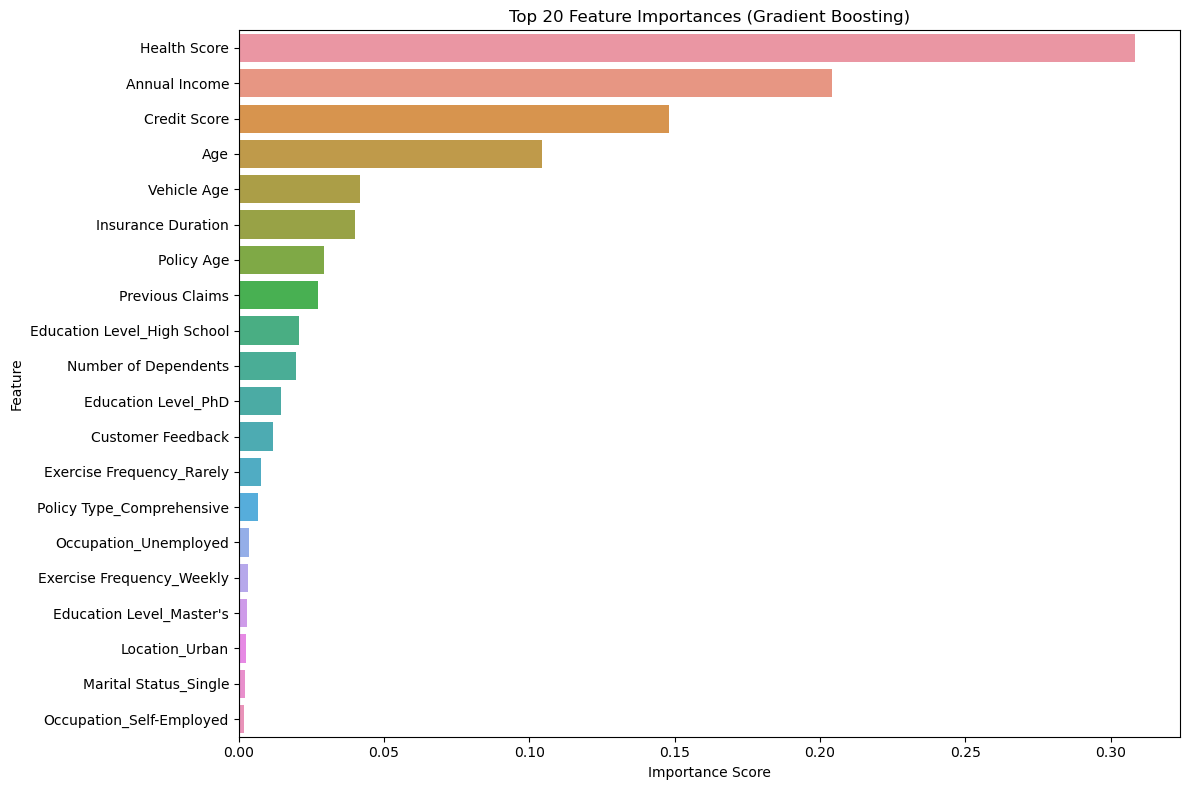

In [2]:
#PHASE 1: Feature Importance Visualization
# Feature Importance Visualization
importances = gbr.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices][:20], y=feature_names[indices][:20])
plt.title("Top 20 Feature Importances (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
#PHASE 2: Hyperparameter Tuning (Grid Search)

from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, 
                    scoring='r2', cv=3, verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

# Best model
best_gbr = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [ ]:
#PHASE 3: SHAP for Model Interpretation
pip install shap


In [ ]:
import shap

# Use TreeExplainer
explainer = shap.Explainer(best_gbr)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)
